<a href="https://colab.research.google.com/github/Liying1996/DL_Drugs/blob/main/Comparison_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_absolute_deviation

from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import pearsonr
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# !sudo fuser /dev/nvidia*
!kill -9 6221

In [ ]:
!nvidia-smi

Fri Feb  5 08:21:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g7hUMVp6YfFIuzHlhQKhGOUiJ4XJbNcRI2KmH8DZejSusbAjPNCaag
Mounted at /content/gdrive


In [ ]:
pkl_file = open('gdrive/MyDrive/AE_results/TDC/gdsc1.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
data.iloc[:,0].value_counts()

PLX-4720       1837
Afatinib       1824
Avagacestat    1823
Olaparib       1819
UNC0638        1803
               ... 
Erlotinib       383
Bortezomib      382
Dasatinib       381
Tozasertib      381
JW-7-52-1       372
Name: ID1, Length: 208, dtype: int64

In [ ]:
tmp = []
for drug in np.unique(data['ID1']):
    data2 = data[data['ID1'] == drug]
    num = len(np.unique(data2['ID2']))
    tmp.append(num)

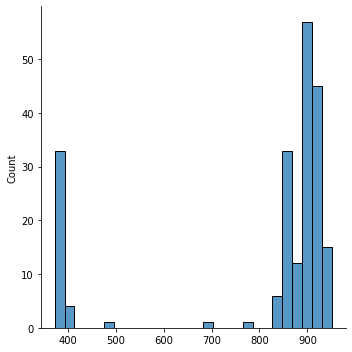

In [ ]:
sns.displot(tmp, kde = False)
plt.show()

In [ ]:
def process_data(drug, data):
    data = data[data.iloc[:,0] == drug]
    labels = np.array(data['Y'])
    new_data = []

    for i in data['X2']:
        for j in i:
            new_data.append(j)

    new_data = np.array(new_data).reshape(-1,17737) 
    return new_data, labels

def scale_data(X_train, X_test):
    scaler = MinMaxScaler()
    new_X_train = scaler.fit_transform(X_train)
    new_X_test = scaler.transform(X_test)
    return new_X_train, new_X_test

def top_mad(X_train, X_test, cut):    
    index = np.argsort(-median_absolute_deviation(X_train))
    new_index = index[:int(X_train.shape[1] * cut)]
    X_train = X_train[:,new_index]
    X_test = X_test[:,new_index]
    return X_train, X_test

In [ ]:
data.head(10)

,ID1,ID2,X1,X2,Y
0,Erlotinib,MC-CAR,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[3.23827250519154, 2.98225419469807, 10.235490...",2.395685
1,Erlotinib,ES3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[8.690197905033282, 3.0914731119366, 9.9924871...",3.140923
2,Erlotinib,ES5,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[8.233101127037282, 2.82468731112752, 10.01588...",3.968757
3,Erlotinib,ES7,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[8.33346622426757, 3.9667571228514302, 9.79399...",2.692768
4,Erlotinib,EW-11,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[8.39134072442845, 2.9683601858810698, 10.2606...",2.478678
5,Erlotinib,SK-ES-1,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[7.87618818572121, 2.8485457282491, 9.28592458...",2.034050
6,Erlotinib,COLO-829,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[7.174121760472291, 2.81185067636675, 10.22149...",2.966952
7,Erlotinib,8-MG-BA,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[7.52634112956323, 3.06990748590601, 10.318838...",2.494802
8,Erlotinib,GB-1,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[5.92819070009575, 2.71914730620312, 9.8462335...",3.604860
9,Erlotinib,U-87-MG,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[6.38052941712957, 3.00025226924604, 10.535739...",3.877827


In [ ]:
new_data = data[data['ID1'] == 'Afatinib']
new_data[new_data['ID2']=='KINGS-1']

,ID1,ID2,X1,X2,Y
126911,Afatinib,KINGS-1,CN(C)C/C=C/C(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=C...,"[6.64976248480386, 2.66900045145122, 9.7413693...",0.858791
168969,Afatinib,KINGS-1,CN(C)C/C=C/C(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=C...,"[6.64976248480386, 2.66900045145122, 9.7413693...",5.021656


In [ ]:
dup = new_data['ID2'].value_counts()[(new_data['ID2'].value_counts() > 1)].index

In [ ]:
len(dup)

886

In [ ]:
d = {}

for i in dup:
    v = new_data[new_data['ID2']==i]['Y']
    d[i] = v.tolist()

In [ ]:
dup_array = np.array([item for item in d.values()])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


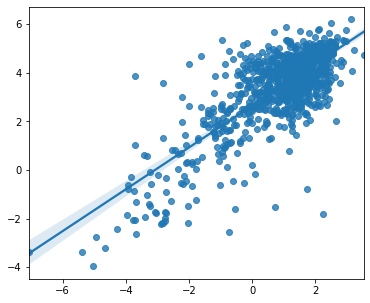

In [ ]:
plt.rcParams['figure.figsize'] = (6, 5)

# plt.scatter(dup_array[:,0], dup_array[:,1])
# plt.show()

sns.regplot(dup_array[:,0], dup_array[:,1])

In [ ]:
pearsonr(dup_array[:,0], dup_array[:,1])

(0.7691956571830527, 4.101911800563979e-174)

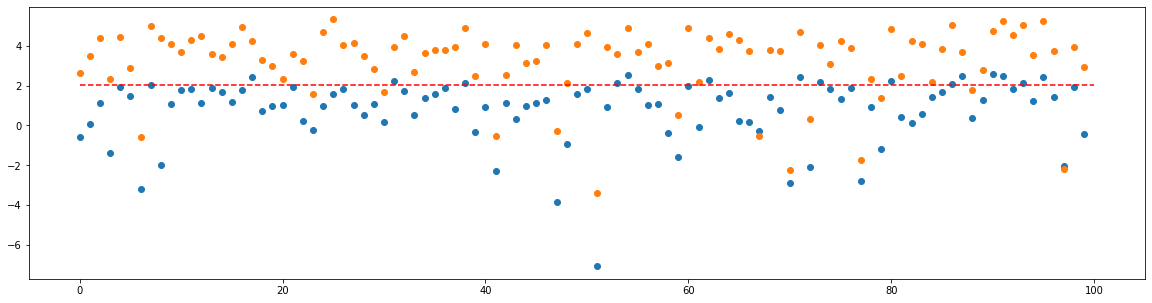

In [ ]:
plt.rcParams['figure.figsize'] = (20, 5)
num = 100
plt.scatter([i for i in range(num)], dup_array[:num,0])
plt.scatter([i for i in range(num)], dup_array[:num,1])
plt.hlines(np.median(new_data['Y']), 0, num, colors = "r", linestyles = "dashed")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


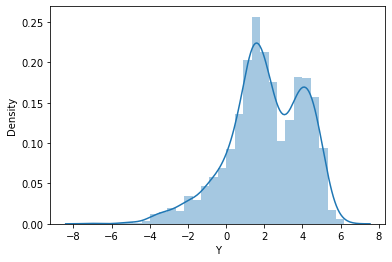

In [ ]:
sns.distplot(new_data['Y'])

In [ ]:
tmp = []
for x in data['X2']:
    x = x.tolist()
    if x not in tmp:
        tmp.append(x)

In [ ]:
gene_expr = np.array(tmp)

In [ ]:
gene_expr.shape

(958, 17737)

In [ ]:
# 如果选择Top20%的数据

val_indexes = random.sample(range(0,958), 192)
train_indexes = [x for x in range(958) if x not in val_indexes]


In [ ]:
X_train = gene_expr[train_indexes]
X_val = gene_expr[val_indexes]

X_train, X_val = top_mad(X_train, X_val, 0.2)
X_train, X_val = scale_data(X_train, X_val)

train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=50)   
val_loader = DataLoader(dataset=torch.from_numpy(X_val).float(), batch_size=50)

NameError: ignored

epoch = 0, train loss = 0.04333299258723855, test_loss = 0.038019428960978985;
epoch = 30, train loss = 0.023768055019900203, test_loss = 0.024323434568941593;
epoch = 60, train loss = 0.020054670865647495, test_loss = 0.022239321377128363;
epoch = 90, train loss = 0.01764155161799863, test_loss = 0.021625285502523184;
epoch = 120, train loss = 0.01611349277663976, test_loss = 0.022499936632812023;
epoch = 150, train loss = 0.016484697232954204, test_loss = 0.02296332037076354;
epoch = 180, train loss = 0.017811338824685663, test_loss = 0.02439060900360346;
epoch = 210, train loss = 0.015031648363219574, test_loss = 0.023563880939036608;
epoch = 240, train loss = 0.012380175001453608, test_loss = 0.02521418035030365;
epoch = 270, train loss = 0.011692923129885457, test_loss = 0.025163661688566208;


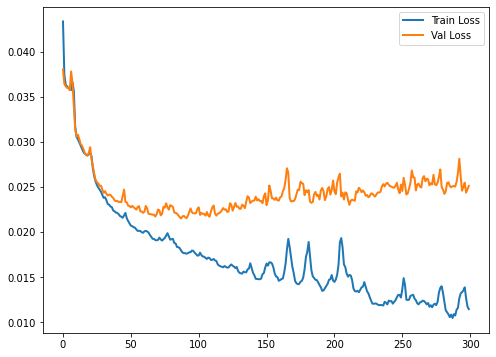

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
AE_train(X_train.shape[1], train_loader, val_loader)
torch.cuda.empty_cache()

epoch = 0, train loss = 0.03279719559941441, test_loss = 0.02451529772952199;
epoch = 30, train loss = 0.01842127658892423, test_loss = 0.01926277205348015;
epoch = 60, train loss = 0.014592694700695574, test_loss = 0.01640334539115429;
epoch = 90, train loss = 0.013613639457616955, test_loss = 0.016232203226536512;
epoch = 120, train loss = 0.013242913380963728, test_loss = 0.01741014886647463;
epoch = 150, train loss = 0.011059070340706967, test_loss = 0.016905587632209063;
epoch = 180, train loss = 0.012432277799234726, test_loss = 0.017735987901687622;
epoch = 210, train loss = 0.009906290018989239, test_loss = 0.017532375175505877;
epoch = 240, train loss = 0.009930926658853423, test_loss = 0.018103279173374176;
epoch = 270, train loss = 0.007881412282586098, test_loss = 0.018965223338454962;


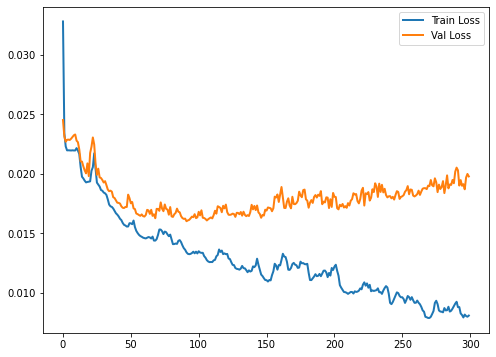

In [ ]:
# 如果用所有的Gene降维

X_train = gene_expr[train_indexes]
X_val = gene_expr[val_indexes]

X_train, X_val = scale_data(X_train, X_val)
train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=50)   
val_loader = DataLoader(dataset=torch.from_numpy(X_val).float(), batch_size=50)

# plt.rcParams['figure.figsize'] = (8, 6)
AE_train(X_train.shape[1], train_loader, val_loader)
torch.cuda.empty_cache()

epoch = 0, train loss = 0.0334717680234462, test_loss = 0.03004499338567257;
epoch = 30, train loss = 0.021644779131747782, test_loss = 0.02180474577471614;
epoch = 60, train loss = 0.018572092172689736, test_loss = 0.01985776051878929;
epoch = 90, train loss = 0.01640533492900431, test_loss = 0.0187196577899158;
epoch = 120, train loss = 0.01630142709473148, test_loss = 0.01961756171658635;
epoch = 150, train loss = 0.015323140542022884, test_loss = 0.019783155992627144;
epoch = 180, train loss = 0.014870460727252066, test_loss = 0.020502686966210604;
epoch = 210, train loss = 0.015093369613168761, test_loss = 0.020178210455924273;
epoch = 240, train loss = 0.013911155489040539, test_loss = 0.019624415319412947;
epoch = 270, train loss = 0.013501701032510027, test_loss = 0.020938501693308353;


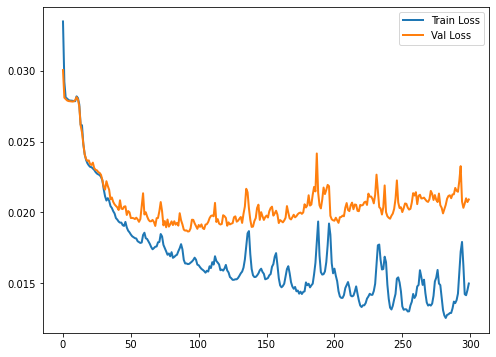

In [ ]:
X_train = gene_expr[train_indexes]
X_val = gene_expr[val_indexes]

X_train, X_val = top_mad(X_train, X_val, 0.5)
X_train, X_val = scale_data(X_train, X_val)
train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=50)   
val_loader = DataLoader(dataset=torch.from_numpy(X_val).float(), batch_size=50)

# plt.rcParams['figure.figsize'] = (8, 6)
AE_train(X_train.shape[1], train_loader, val_loader)
torch.cuda.empty_cache()

epoch = 0, train loss = 0.036421341239474714, test_loss = 0.02669014362618327;
epoch = 30, train loss = 0.018765825778245926, test_loss = 0.02057280484586954;
epoch = 60, train loss = 0.01581788156181574, test_loss = 0.017757606226950884;
epoch = 90, train loss = 0.015567555034067482, test_loss = 0.018102131318300962;
epoch = 120, train loss = 0.013419573340797797, test_loss = 0.017197954934090376;
epoch = 150, train loss = 0.013045138155575842, test_loss = 0.018266889732331038;
epoch = 180, train loss = 0.011646227241726592, test_loss = 0.018400727305561304;
epoch = 210, train loss = 0.011314578412566334, test_loss = 0.018192369490861893;
epoch = 240, train loss = 0.011248320952290669, test_loss = 0.018584035336971283;
epoch = 270, train loss = 0.008620061191322748, test_loss = 0.018580820877104998;


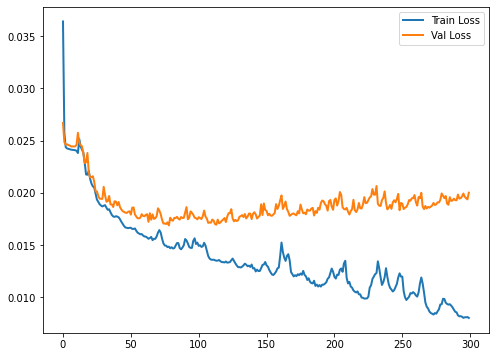

In [ ]:
X_train = gene_expr[train_indexes]
X_val = gene_expr[val_indexes]

X_train, X_val = top_mad(X_train, X_val, 0.8)
X_train, X_val = scale_data(X_train, X_val)
train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=30)   
val_loader = DataLoader(dataset=torch.from_numpy(X_val).float(), batch_size=30)

# plt.rcParams['figure.figsize'] = (8, 6)
AE_train(X_train.shape[1], train_loader, val_loader)
torch.cuda.empty_cache()

In [ ]:
# datatloader
class RegressionDataset(Dataset):   
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


# AE framework

class AE(nn.Module):
    def __init__(self, input_size):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 3000),
            nn.BatchNorm1d(num_features=3000),
            nn.ReLU(),
            nn.Linear(3000, 1000),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(1000, 500)
        )
        self.decoder = nn.Sequential(
            nn.Linear(500, 1000),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(1000, 3000),
            nn.BatchNorm1d(num_features=3000),
            nn.ReLU(),
            nn.Linear(3000, input_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return encoder,decoder


In [ ]:
class AE2(nn.Module):
    def __init__(self, input_size):
        super(AE2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 500),
            nn.ReLU(),
            nn.Linear(500, input_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return encoder,decoder

In [ ]:
def classic_reg(X_train, y_train, X_test, method):
    if method == 'rf':
        rg = RandomForestRegressor()
    if method == 'svr':
        rg = SVR(kernel='rbf')
    if method == 'elasticnet':
        rg = ElasticNet()

    rg.fit(X_train, y_train)
    test_pred = rg.predict(X_test)
    return test_pred

def evaluate(y_test, test_pred):
    r2 = r2_score(y_test, test_pred)
    mse = mean_squared_error(y_test, test_pred)   
    pccs = pearsonr(y_test, test_pred)
    
    # print("Method = {}, r2_score = {}, MSE = {}, PCC = {}, PCC_p".format(method, r2, mse, pccs[0], pccs[1]))
    return r2, mse, pccs[0]

In [ ]:
def AE_train(input_size, train_loader, test_loader):
    model = AE(input_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  
    all_train_loss = []
    all_test_loss = []

    for epoch in range(50):
        train_loss = 0
        model.train()
        for x in train_loader:   
            # model.train()   
            x = x.cuda()
            _, x_hat = model(x)
            loss = criterion(x_hat, x)

            # backprop
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
        
        with torch.no_grad():
            model.eval()
            test_loss = 0

            for x in test_loader:
                # model.eval()
                x = x.cuda()

                _, x_hat = model(x)
                loss = criterion(x_hat, x)

                test_loss += loss.item()

        all_train_loss.append(train_loss/len(train_loader))
        all_test_loss.append(test_loss/len(test_loader))
        # if epoch % 30 == 0:
        #     print('epoch = {}, train loss = {}, test_loss = {};'.format(epoch,\
        #                                         train_loss/len(train_loader), test_loss/len(test_loader)))
        
    plt.plot([x for x in range(50)], all_train_loss, label='Train Loss', linewidth=2)
    plt.plot([y for y in range(50)], all_test_loss, label='Val Loss', linewidth=2)
    plt.legend()
    plt.show()
    return model

In [ ]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_size):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, 3000)
        self.fc21 = nn.Linear(3000, 500)
        self.fc22 = nn.Linear(3000, 500)
        self.fc3 = nn.Linear(500, 3000)
        self.fc4 = nn.Linear(3000, input_size)
        
    # 编码
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码
    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = self.fc4(h)
        return torch.sigmoid(h)
        # return h
    
    # 前向传播
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [ ]:
# def loss_function(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return BCE + KLD

def loss_function(recon_x, x, mu, logvar):
    loss = nn.MSELoss(reduction="sum")
    loss_MSE = loss(recon_x, x)
    loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss_MSE*0.5 + loss_KLD

def VAE_train(input_size, train_loader, test_loader):
    model2 = VAE(input_size).to(device)
    optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)  

    all_train_loss = []
    all_test_loss = []

    for epoch in range(100):
        train_loss = 0
        model2.train()
        for x in train_loader:   
            # model2.train()   
            x = x.cuda()
            x_reconst, mu, log_var = model2(x)
            loss = loss_function(x_reconst, x, mu, log_var)

            # backprop
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            train_loss += loss.item()
        
        with torch.no_grad():
            model2.eval()
            test_loss = 0

            for x in test_loader:
                # model2.eval()
                x = x.cuda()

                x_reconst, mu, log_var = model2(x)
                loss = loss_function(x_reconst, x, mu, log_var)

                test_loss += loss.item()

        all_train_loss.append(train_loss/len(train_loader))
        all_test_loss.append(test_loss/len(test_loader))
        # if epoch % 20 == 0:
        #     print('epoch = {}, train loss = {}, test_loss = {};'.format(epoch,\
        #                                         train_loss/len(train_loader), test_loss/len(test_loader)))
        
    plt.plot([x for x in range(100)], all_train_loss, label='Train Loss', linewidth=2)
    plt.plot([y for y in range(100)], all_test_loss, label='Val Loss', linewidth=2)
    plt.legend()
    plt.show()

    return model2

### ======== LOAD data ========

In [ ]:
import scipy.io as scio

In [ ]:
data_file = 'gdrive/MyDrive/AE_results/MC_PR_Data/CCLE_X.mat'
data = scio.loadmat(data_file)
gene_expr = data['X']

In [ ]:
gene_expr.shape

(491, 18900)

In [ ]:
test_file = 'gdrive/MyDrive/AE_results/MC_PR_Data/MMnormal.mat'
test = scio.loadmat(test_file)
labels = test['MM']

epoch = 0, train loss = 0.03957434544073684, test_loss = 0.03302457928657532;
epoch = 30, train loss = 0.017899448738067543, test_loss = 0.021785200107842684;
epoch = 60, train loss = 0.013094081167115032, test_loss = 0.020553247537463903;
epoch = 90, train loss = 0.010295367514897538, test_loss = 0.021068483125418425;
epoch = 120, train loss = 0.007696438869710879, test_loss = 0.02152658486738801;


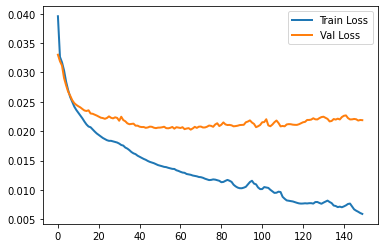

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train, X_test, y_train, y_test = train_test_split(gene_expr, labels[:,5], test_size=0.2, random_state=42)

X_train, X_test = top_mad(X_train, X_test, cut=0.5)
X_train, X_test = scale_data(X_train, X_test)

train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=30)   
test_loader = DataLoader(dataset=torch.from_numpy(X_test).float(), batch_size=30)

model = AE_train(X_train.shape[1], train_loader, test_loader)
torch.cuda.empty_cache()

In [ ]:
train_encoder, _ = model(torch.from_numpy(X_train).float().cuda())
test_encoder, _ = model(torch.from_numpy(X_test).float().cuda())

X_train = train_encoder.cpu().detach().numpy()
X_test = test_encoder.cpu().detach().numpy()

In [ ]:
np.sum(np.all(np.equal(X_test, 0), axis=0))

300

In [ ]:
methods = ['rf', 'svr']
all_r2 = [0, 0]
all_mse = [0, 0]
all_pcc = [0, 0]
for j in range(2):
    test_pred = classic_reg(X_train, y_train, X_test, method=methods[j])
    r2, mse, pcc = evaluate(y_test, test_pred)
    all_r2[j] += r2
    all_mse[j] += mse
    all_pcc[j] += pcc
print(all_r2)
print(all_mse)
print(all_pcc)

[0.26101867640199683, 0.276616227634937]
[0.38016695394571365, 0.3721428356738631]
[0.5188503731326187, 0.5262891821278278]


In [ ]:

param_grid = [
              {
                    "kernel": ['poly', 'rbf', 'sigmoid', 'linear'],
                    "C": [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 5]
              },
              {
                  "kernel":["poly"],
                  "degree": [i for i in range(1,8)],
                  "C": [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 5]
              }
]

svr_clf = SVR()

grid_search = GridSearchCV(svr_clf, param_grid, n_jobs = -1, verbose = -2, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  8.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 5],
                          'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
                         {'C': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 5],
                          'degree': [1, 2, 3, 4, 5, 6, 7],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=-2)

In [ ]:
best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_test)
evaluate(y_test, test_pred)

(0.4385956269460817, 0.5170701787339453, 0.6910394276713394)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(gene_expr, labels[:,3], test_size=0.2, random_state=42)
X_train, X_test = top_mad(X_train, X_test, cut=0.5)
X_train, X_test = scale_data(X_train, X_test)

methods = ['rf', 'svr']
all_r2 = [0, 0, 0]
all_mse = [0, 0, 0]
all_pcc = [0, 0, 0]

for j in range(2):
    test_pred = classic_reg(X_train, y_train, X_test, method=methods[j])
    r2, mse, pcc = evaluate(y_test, test_pred)
    

In [ ]:
# 选择top50%

X_train, X_test, y_train, y_test = train_test_split(gene_expr, labels[:,3], test_size=0.2, random_state=42)
X_train, X_test = scale_data(X_train, X_test)

methods = ['rf', 'svr']
all_r2 = [0, 0, 0]
all_mse = [0, 0, 0]
all_pcc = [0, 0, 0]

for j in range(2):
    test_pred = classic_reg(X_train, y_train, X_test, method=methods[j])
    r2, mse, pcc = evaluate(y_test, test_pred)
    all_r2[j] += r2
    all_mse[j] += mse
    all_pcc[j] += pcc

print(all_r2)
print(all_mse)
print(all_pcc)

[0.2492294680314987, 0.3600303032791433, 0]
[0.6914820613907983, 0.5894311860587894, 0]
[0.5067420009907924, 0.6462436535526577, 0]


In [ ]:
from sklearn.decomposition import PCA 

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


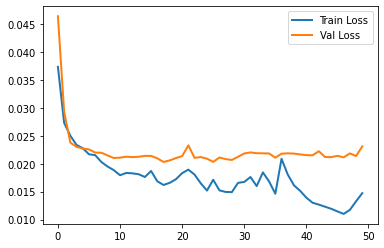

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


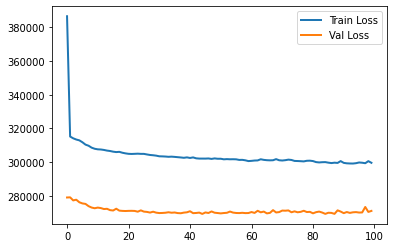

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


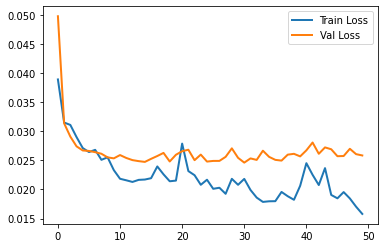

=====> Use MAD top50% to VAE to SVM <=====


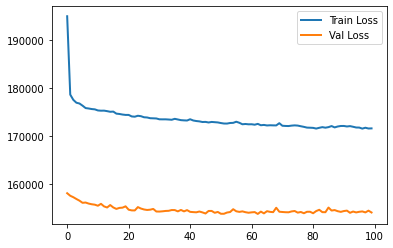

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


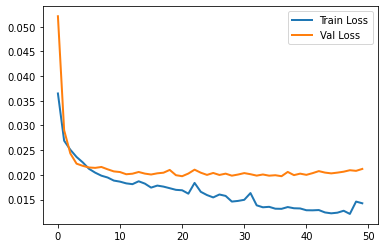

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


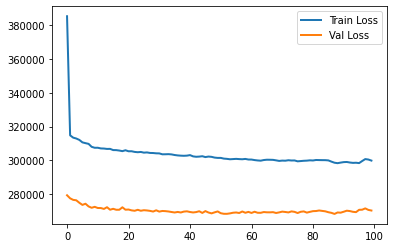

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


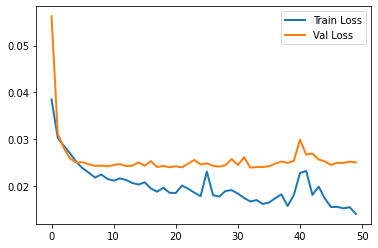

=====> Use MAD top50% to VAE to SVM <=====


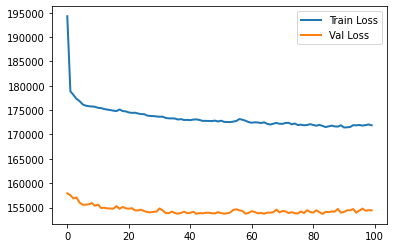

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


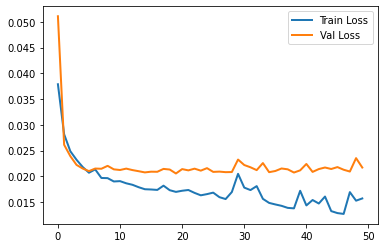

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


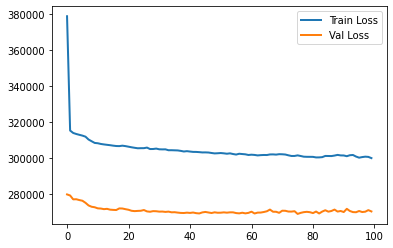

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


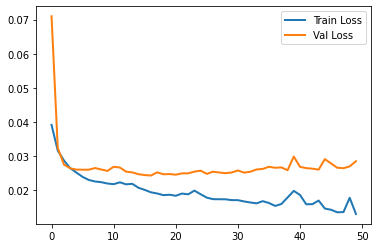

=====> Use MAD top50% to VAE to SVM <=====


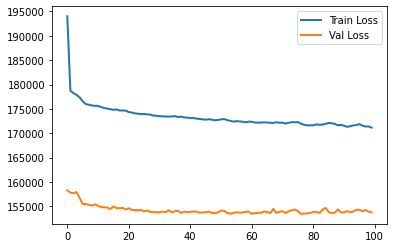

[0.538362631482994, 0.5071954359966752, 0.6136588899189112]
[0.5175494586297191, 0.4962033626955295, 0.6086481856144118]
[0.5038850977985659, 0.5097156129419588, 0.6166595913324923]
[0.5018438057525537, 0.39576945162128113, 0.4933777179212588]
[0.39216696566467235, 0.2517376353346886, 0.5125045530284117]
[0.5151927366425124, 0.48035241123192324, 0.5942474123463197]
[0.4926935426150367, 0.46412336758351896, 0.5794028932178464]
[0.4493691846412009, 0.3912140111568082, 0.5309554516088666]
[0.3536452401889486, 0.4308183864666644, 0.45226512906265315]
=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


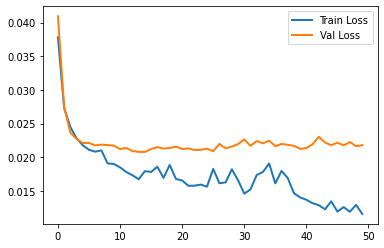

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


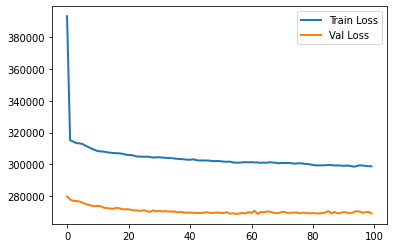

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


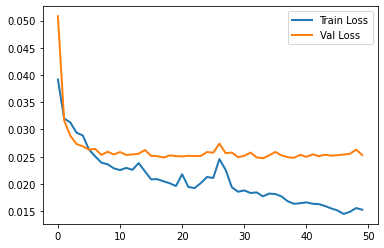

=====> Use MAD top50% to VAE to SVM <=====


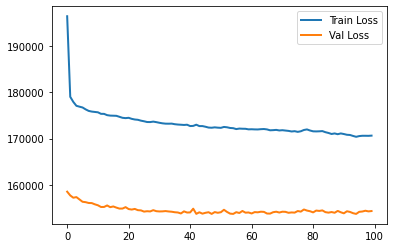

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


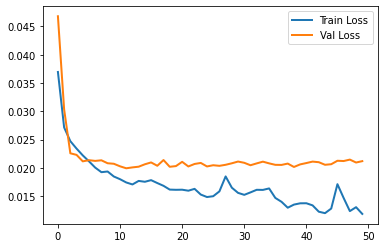

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


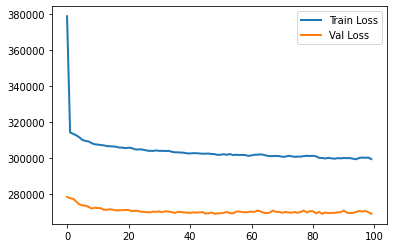

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


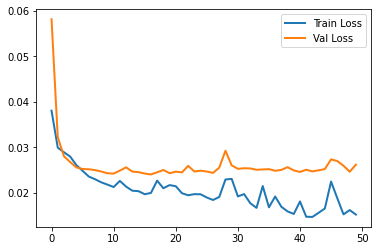

=====> Use MAD top50% to VAE to SVM <=====


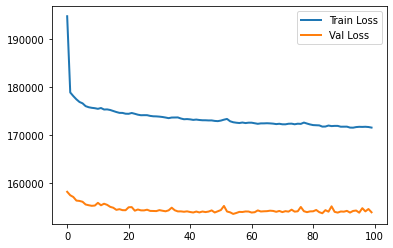

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


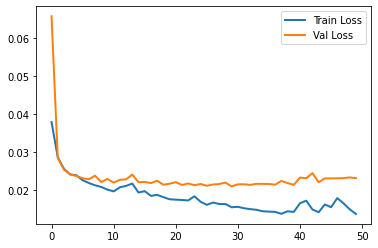

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


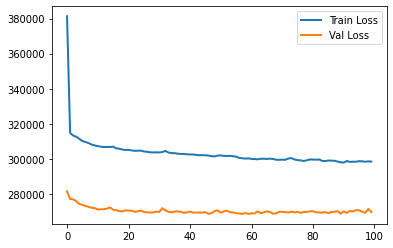

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


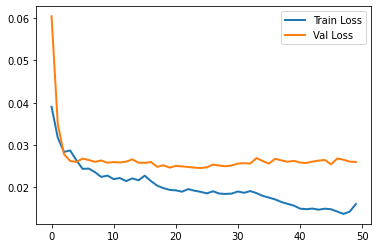

=====> Use MAD top50% to VAE to SVM <=====


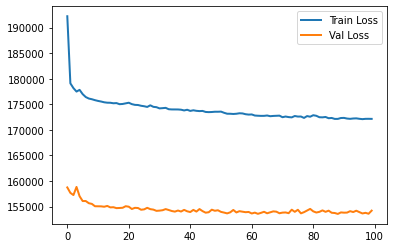

[0.39613839276002344, 0.3798041673722639, 0.4256672554940096]
[0.40171716224675497, 0.40271229136901293, 0.46109114038540755]
[0.4840989808484847, 0.403001151193577, 0.45492741780739737]
[0.291813609261329, 0.2874576141964425, 0.5230154120969361]
[0.34321193691127794, 0.1776357039768856, 0.4765795492520519]
[0.4039121939154366, 0.4076263207843726, 0.4781585406312664]
[0.40772414143607993, 0.40864105314010596, 0.49379864871664636]
[0.42337621896494676, 0.3976622066361715, 0.5406566651686756]
[0.4324701696645807, 0.38617609399038605, 0.57022670646878]
=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


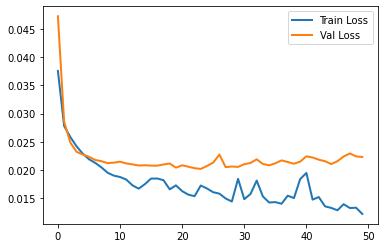

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


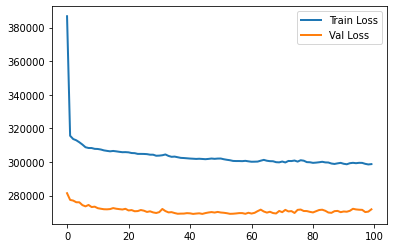

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


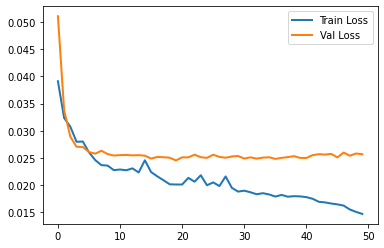

=====> Use MAD top50% to VAE to SVM <=====


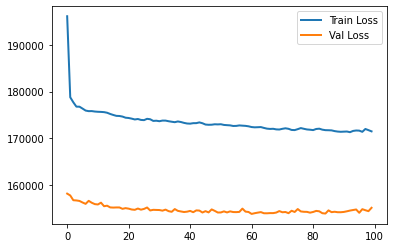

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


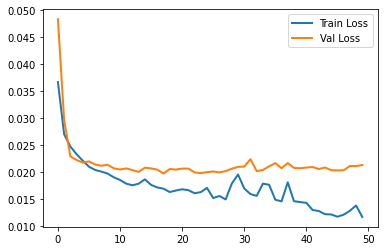

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


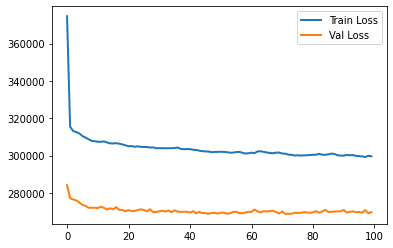

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


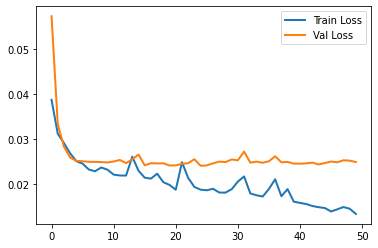

=====> Use MAD top50% to VAE to SVM <=====


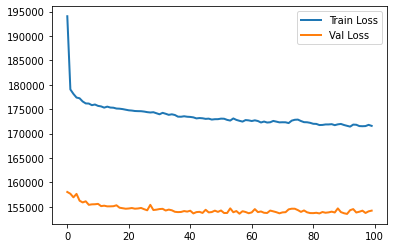

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


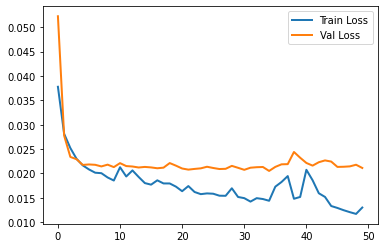

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


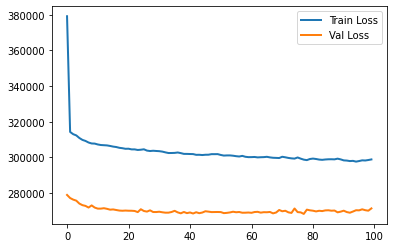

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


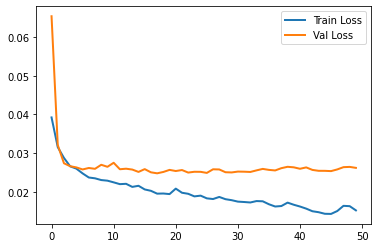

=====> Use MAD top50% to VAE to SVM <=====


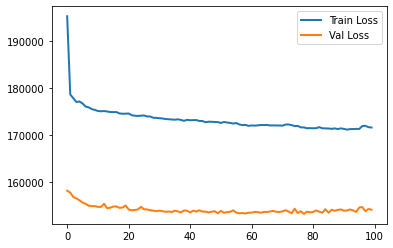

[0.2574221936177525, 0.3179161394852025, 0.13507369053779766]
[0.24978423716212997, 0.3059803123833954, 0.1320012227846171]
[0.1652493352677022, 0.3778228539735957, 0.06313678706618417]
[0.2633452305318076, 0.20993684949998256, 0.0633184662801416]
[0.19185791281391498, 0.2886922022857914, 0.13399900824952568]
[0.25478725239454997, 0.31845182526473004, 0.09555902090523437]
[0.2324752769995107, 0.3114347533186295, 0.10983174252389193]
[0.22137043177852514, 0.2461050649215878, 0.05152073246988663]
[0.21331344405322025, 0.11889907362205161, 0.016926242913431415]
=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


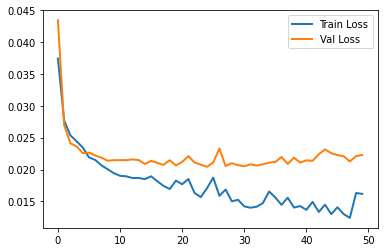

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


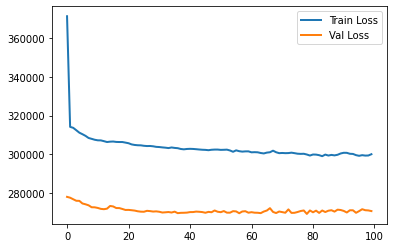

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


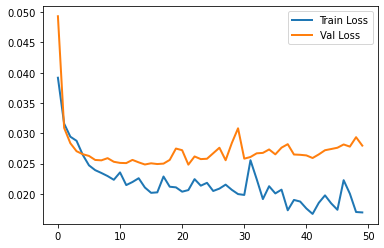

=====> Use MAD top50% to VAE to SVM <=====


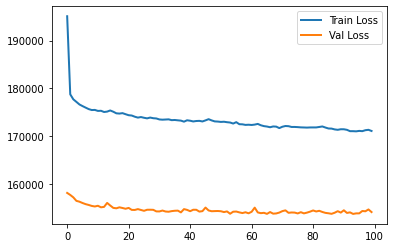

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


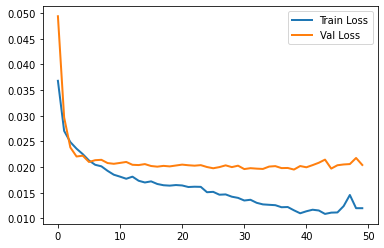

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


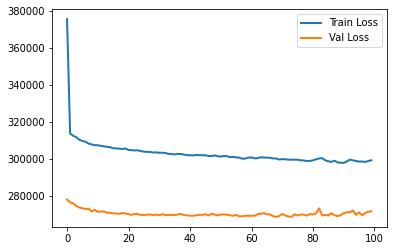

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


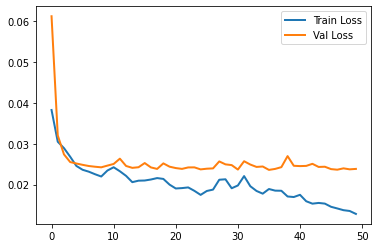

=====> Use MAD top50% to VAE to SVM <=====


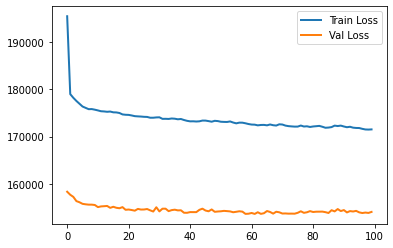

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


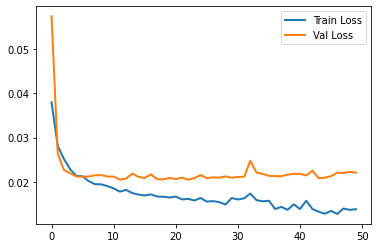

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


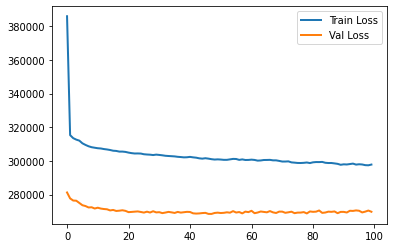

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


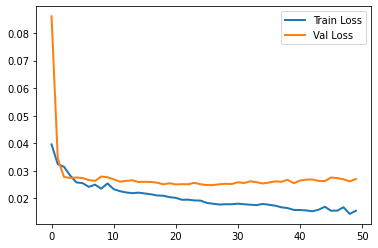

=====> Use MAD top50% to VAE to SVM <=====


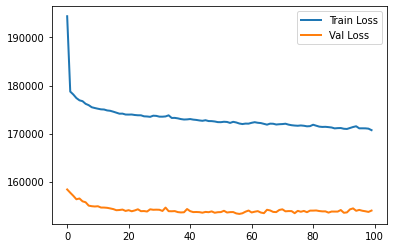

[0.6281454179065026, 0.5486036138759086, 0.5971207779866873]
[0.616184218765369, 0.560932461102106, 0.6045183124931123]
[0.619802552527842, 0.5629795303969103, 0.6290979232189539]
[0.6220239955561284, 0.5130280144647461, 0.5430100529691639]
[0.5587871532852574, 0.5023755876953989, 0.558239816421477]
[0.6075565417857349, 0.5177922929791637, 0.5849761392365412]
[0.6069003283486404, 0.5274292912051411, 0.5901567406008426]
[0.539955259730399, 0.5154421700795312, 0.5945781829227998]
[0.48963245078074125, 0.5205526749223401, 0.6036693177377445]
=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


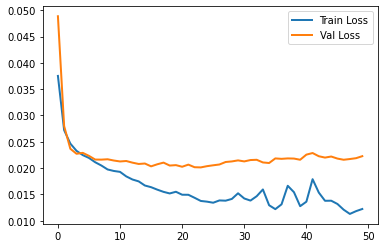

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


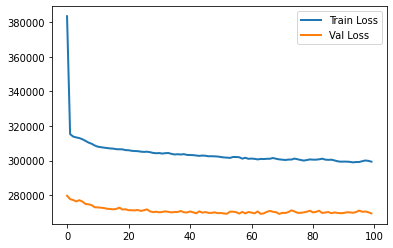

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


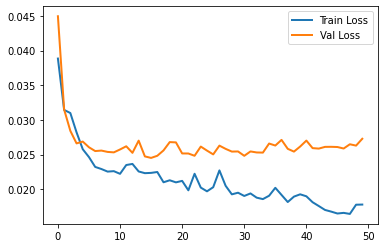

=====> Use MAD top50% to VAE to SVM <=====


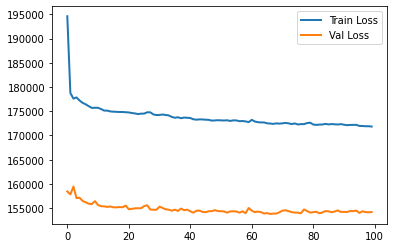

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


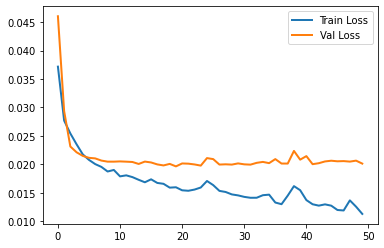

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


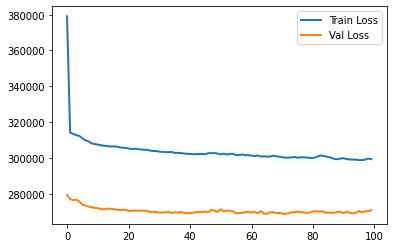

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


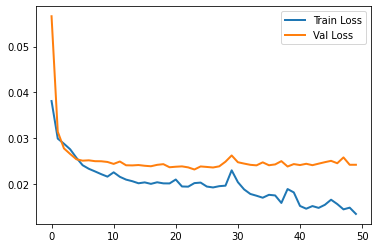

=====> Use MAD top50% to VAE to SVM <=====


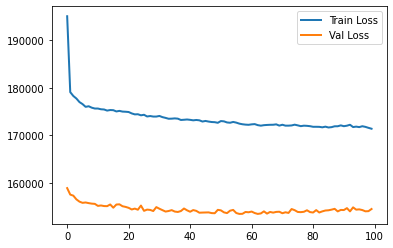

=====> Use all genes to SVM <=====
=====> Use all genes to PCA <=====
=====> Use all genes to AE to SVM <=====


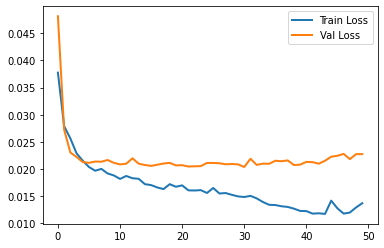

=====> Use all genes to do feature selection to SVM <=====
=====> Use all genes to VAE to SVM <=====


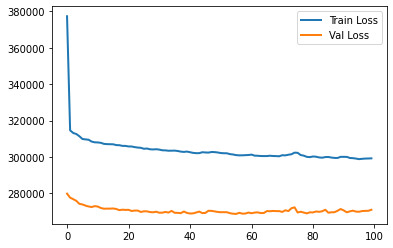

=====> Use MAD Top50% to SVM <=====
=====> Use MAD top50% to PCA to SVM <====
=====> Use MAD Top50% to AE to SVM <=====


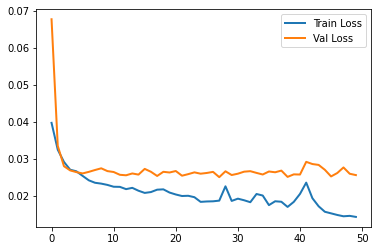

=====> Use MAD top50% to VAE to SVM <=====


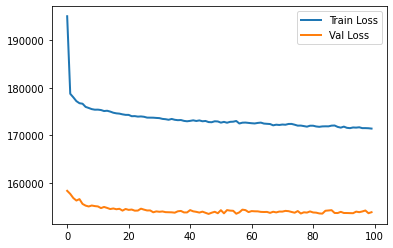

[0.38045953746013705, 0.38480846278255376, 0.3539234863901957]
[0.37863873221375605, 0.3802327821581914, 0.3841049088196935]
[0.46428061320302566, 0.3950549069924804, 0.33781558493899605]
[0.317862705971536, 0.3914706009457036, 0.35350477355088183]
[0.38692223626585, 0.4287647614504027, 0.35191478086675]
[0.3511296994825899, 0.437434338565841, 0.36386201741647367]
[0.35160621419262494, 0.41122963219179604, 0.37609172328508234]
[0.42717932316322627, 0.43771803137524373, 0.35559901965694707]
[0.3555394897214401, 0.3506654529231045, 0.3501546230753697]


In [ ]:


# for train_index , test_index in kf.split(gene_expr):
    # X_train = gene_expr[train_index]    
    # y_train = labels[:,3][train_index]
    # X_test = gene_expr[test_index]
    # y_test = labels[:,3][test_index]

all_drug_res = []
for d in range(5):
    pcc_all, pcc_top, pcc_SK_all, pcc_pca_all, pcc_pca_top, pcc_AE_all, pcc_AE_top, pcc_VAE_all, pcc_VAE_top = [], [], [], [], [], [], [], [], []
    for t in range(3):
        X_train, X_test, y_train, y_test = train_test_split(gene_expr, labels[:,d], test_size=0.2, random_state=t*3)
        X_train, X_test = scale_data(X_train, X_test)
    
        print('=====> Use all genes to SVM <=====')   
        test_pred = classic_reg(X_train, y_train, X_test, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_all.append(pcc)


        print('=====> Use all genes to PCA <=====')

        pca = PCA(n_components=100)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        test_pred = classic_reg(X_train_pca, y_train, X_test_pca, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_pca_all.append(pcc)


        print('=====> Use all genes to AE to SVM <=====')   
        train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=30)   
        test_loader = DataLoader(dataset=torch.from_numpy(X_test).float(), batch_size=30)

        model = AE_train(X_train.shape[1], train_loader, test_loader)
        torch.cuda.empty_cache()

        train_encoder, _ = model(torch.from_numpy(X_train).float().cuda())
        test_encoder, _ = model(torch.from_numpy(X_test).float().cuda())

        X_train_ae = train_encoder.cpu().detach().numpy()
        X_test_ae = test_encoder.cpu().detach().numpy()
        
        test_pred = classic_reg(X_train_ae, y_train, X_test_ae, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_AE_all.append(pcc)


        print("=====> Use all genes to do feature selection to SVM <=====")
        selector = SelectKBest(f_regression, k=500)
        X_train_new = selector.fit_transform(X_train, y_train)
        X_test_new = selector.transform(X_test)

        test_pred = classic_reg(X_train_new, y_train, X_test_new, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_SK_all.append(pcc)

        print("=====> Use all genes to VAE to SVM <=====")
        model2 = VAE_train(X_train.shape[1], train_loader, test_loader)
        torch.cuda.empty_cache()    
        x_reconst, train_encoder, log_var = model2(torch.from_numpy(X_train).float().cuda())
        x_reconst, test_encoder, log_var = model2(torch.from_numpy(X_test).float().cuda())
        
        X_train_vae = train_encoder.cpu().detach().numpy()
        X_test_vae = test_encoder.cpu().detach().numpy()
        
        test_pred = classic_reg(X_train_vae, y_train, X_test_vae, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_VAE_all.append(pcc)   

        print('=====> Use MAD Top50% to SVM <=====')
        X_train, X_test = top_mad(X_train, X_test, cut=0.5)
        test_pred = classic_reg(X_train, y_train, X_test, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_top.append(pcc)


        print('=====> Use MAD top50% to PCA to SVM <====')
        pca = PCA(n_components=100)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        test_pred = classic_reg(X_train_pca, y_train, X_test_pca, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_pca_top.append(pcc)


        print('=====> Use MAD Top50% to AE to SVM <=====')
        
        train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=30)   
        test_loader = DataLoader(dataset=torch.from_numpy(X_test).float(), batch_size=30)

        model = AE_train(X_train.shape[1], train_loader, test_loader)
        torch.cuda.empty_cache()

        train_encoder, _ = model(torch.from_numpy(X_train).float().cuda())
        test_encoder, _ = model(torch.from_numpy(X_test).float().cuda())

        X_train_ae = train_encoder.cpu().detach().numpy()
        X_test_ae = test_encoder.cpu().detach().numpy()
        
        test_pred = classic_reg(X_train_ae, y_train, X_test_ae, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_AE_top.append(pcc)

        print("=====> Use MAD top50% to VAE to SVM <=====")
        model2 = VAE_train(X_train.shape[1], train_loader, test_loader)
        torch.cuda.empty_cache()    
        x_reconst, train_encoder, log_var = model2(torch.from_numpy(X_train).float().cuda())
        x_reconst, test_encoder, log_var = model2(torch.from_numpy(X_test).float().cuda())
        
        X_train_vae = train_encoder.cpu().detach().numpy()
        X_test_vae = test_encoder.cpu().detach().numpy()
        
        test_pred = classic_reg(X_train_vae, y_train, X_test_vae, method='svr')
        r2, mse, pcc = evaluate(y_test, test_pred) 
        pcc_VAE_top.append(pcc)  

    print(pcc_all)
    print(pcc_top)
    print(pcc_SK_all)
    print(pcc_AE_all)
    print(pcc_AE_top)
    print(pcc_pca_all)
    print(pcc_pca_top)
    print(pcc_VAE_all)
    print(pcc_VAE_top)
    
    all_drug_res.append(pcc_all)
    all_drug_res.append(pcc_top)
    all_drug_res.append(pcc_SK_all)
    all_drug_res.append(pcc_AE_all)
    all_drug_res.append(pcc_AE_top)
    all_drug_res.append(pcc_pca_all)
    all_drug_res.append(pcc_pca_top)
    all_drug_res.append(pcc_VAE_all)
    all_drug_res.append(pcc_VAE_top)


In [ ]:
col1 = []
for i in all_drug_res:
    for j in i:
        col1.append(j)
col2 = []        
tmp = ['SVM', 'top_SVM', 'SK_SVM', 'AE_SVM', 'top_AE_SVM', 'PCA_SVM', 'top_PCA_SVM', 'VAE_SVM', 'top_VAE_SVM']
for m in range(5):
    for i in tmp:
        for j in range(3):
            col2.append(i)
col3 = []
for i in range(5):
    for j in range(27):
        col3.append(i)

In [ ]:
from pandas.core.frame import DataFrame
res={"PCC" : col1,
   "method" : col2,
   "drug":col3}
res=DataFrame(res)
print(res)

          PCC       method  drug
0    0.538363          SVM     0
1    0.507195          SVM     0
2    0.613659          SVM     0
3    0.517549      top_SVM     0
4    0.496203      top_SVM     0
..        ...          ...   ...
130  0.437718      VAE_SVM     4
131  0.355599      VAE_SVM     4
132  0.355539  top_VAE_SVM     4
133  0.350665  top_VAE_SVM     4
134  0.350155  top_VAE_SVM     4

[135 rows x 3 columns]


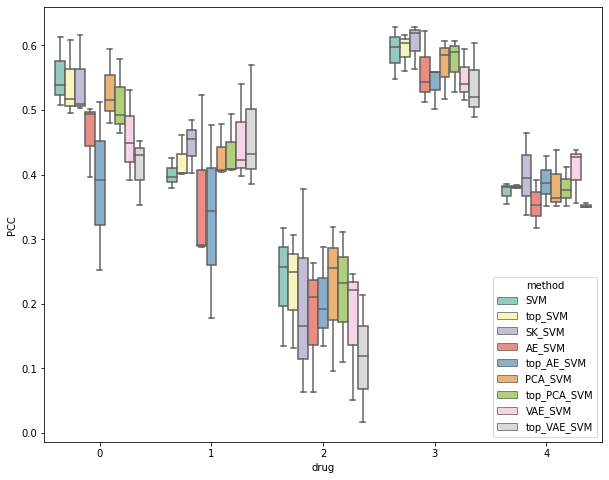

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)

ax = sns.boxplot(x="drug", y="PCC", hue="method",
                 data=res, palette="Set3")

In [ ]:
print(sum(pcc_all)/5)
print(sum(pcc_top)/5)
print(sum(pcc_AE_all)/5)
print(sum(pcc_AE_top)/5)
print(sum(pcc_pca_all)/5)
print(sum(pcc_pca_top)/5)
print(sum(pcc_VAE_all)/5)
print(sum(pcc_VAE_top)/5)

0.6081555946993292
0.6095363110036335
0.5273588240229188
0.5506087204617298
0.5879829316483004
0.5920679975867807
0.5477991817454434
0.5412530977656277


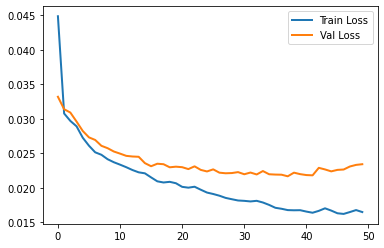

0.5763184725925236


In [ ]:
X_train = gene_expr[train_index]    
y_train = labels[:,3][train_index]
X_test = gene_expr[test_index]
y_test = labels[:,3][test_index]

X_train, X_test = top_mad(X_train, X_test, cut=0.8)
X_train, X_test = scale_data(X_train, X_test)

train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=30)   
test_loader = DataLoader(dataset=torch.from_numpy(X_test).float(), batch_size=30)

model = AE_train(X_train.shape[1], train_loader, test_loader)
torch.cuda.empty_cache()

train_encoder, _ = model(torch.from_numpy(X_train).float().cuda())
test_encoder, _ = model(torch.from_numpy(X_test).float().cuda())

X_train_ae = train_encoder.cpu().detach().numpy()
X_test_ae = test_encoder.cpu().detach().numpy()

test_pred = classic_reg(X_train_ae, y_train, X_test_ae, method='svr')
r2, mse, pcc = evaluate(y_test, test_pred) 
print(pcc)

In [ ]:
test_pred = classic_reg(X_train, y_train, X_test, method='svr')
r2, mse, pcc = evaluate(y_test, test_pred) 
print(pcc)

0.6169271805689046


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=500)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

# train_loader = DataLoader(dataset=torch.from_numpy(X_train_new).float(), batch_size=30)   
# test_loader = DataLoader(dataset=torch.from_numpy(X_test_new).float(), batch_size=30)

# model = AE_train(X_train_new.shape[1], train_loader, test_loader)
# torch.cuda.empty_cache()

# train_encoder, _ = model(torch.from_numpy(X_train_new).float().cuda())
# test_encoder, _ = model(torch.from_numpy(X_test_new).float().cuda())

# X_train_ae = train_encoder.cpu().detach().numpy()
# X_test_ae = test_encoder.cpu().detach().numpy()

test_pred = classic_reg(X_train_new, y_train, X_test_new, method='svr')
r2, mse, pcc = evaluate(y_test, test_pred) 
print(pcc)

0.6450930155911893


In [ ]:
!pip install unidip

In [ ]:

from unidip import UniDip

indexes = []

for num in range(gene_expr.shape[1]):
    intervals = UniDip(np.msort(gene_expr[:,num])).run()
    if len(intervals) > 1:
        indexes.append(num)

with open('gdrive/MyDrive/AE_results/MC_PR_Data/uni_index.txt', 'w') as f:
    for i in indexes:
        f.write(str(i) + '\n')

In [ ]:
with open("gdrive/MyDrive/AE_results/MC_PR_Data/uni_index.txt", 'r') as f:
    for line in f:
        line = line.strip()
        

12015

In [ ]:
test_pred = classic_reg(X_train_new, y_train, X_test_new, method='svr')
r2, mse, pcc = evaluate(y_test, test_pred) 
print(pcc)

0.6370590333157454


In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_pred = classic_reg(X_train_new, y_train, X_test_new, method='svr')
r2, mse, pcc = evaluate(y_test, test_pred) 
print(pcc)

0.6370590333157454


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(gene_expr, labels[:,3], test_size=0.2, random_state=1)

X_train, X_test = scale_data(X_train, X_test)

selector = SelectKBest(f_regression, k=1000)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

# kernel = RBF()
# gp = GaussianProcessRegressor(kernel=kernel,
#                               alpha=1.0)

# gp.fit(X_train_new, y_train)
test_pred = classic_reg(X_train_new, y_train, X_test_new, method='svr')
# test_pred = gp.predict(X_test_new)
r2, mse, pcc = evaluate(y_test, test_pred)
print(pcc)

0.5838109696632693


In [ ]:
import lightgbm as lgb

In [ ]:
# X_train = gene_expr[train_index]    
# y_train = labels[:,3][train_index]
# X_test = gene_expr[test_index]
# y_test = labels[:,3][test_index]

# X_train, X_test = scale_data(X_train, X_test)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)

Starting training...
[1]	valid_0's l1: 0.786035	valid_0's l2: 0.920553
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l1: 0.775187	valid_0's l2: 0.899949
[3]	valid_0's l1: 0.768269	valid_0's l2: 0.884213
[4]	valid_0's l1: 0.762418	valid_0's l2: 0.872678
[5]	valid_0's l1: 0.756803	valid_0's l2: 0.861606
[6]	valid_0's l1: 0.749381	valid_0's l2: 0.843846
[7]	valid_0's l1: 0.741698	valid_0's l2: 0.827516
[8]	valid_0's l1: 0.736753	valid_0's l2: 0.812248
[9]	valid_0's l1: 0.734431	valid_0's l2: 0.803138
[10]	valid_0's l1: 0.727692	valid_0's l2: 0.788866
[11]	valid_0's l1: 0.722915	valid_0's l2: 0.774694
[12]	valid_0's l1: 0.719021	valid_0's l2: 0.762519
[13]	valid_0's l1: 0.715087	valid_0's l2: 0.751139
[14]	valid_0's l1: 0.711676	valid_0's l2: 0.745265
[15]	valid_0's l1: 0.706358	valid_0's l2: 0.736017
[16]	valid_0's l1: 0.703069	valid_0's l2: 0.730581
[17]	valid_0's l1: 0.698761	valid_0's l2: 0.724213
[18]	valid_0's l1: 0.694046	valid_0's l2: 0.711878
[19]	va

In [ ]:
test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
evaluate(y_test, test_pred)


(0.3689321777368789, 0.5792101819745835, 0.624768286934847)